# Description

SVM one-vs-rest classifier on scaled PCA components that explained 95% variance for HOG, SIFT, CANNY and CNN feature vector matrix.



# Load libraries

In [1]:
# standard
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
from tqdm import tqdm
import pprint # pretty printing dictionaries
import re
import os
import shutil
import joblib
import cv2
import time


# classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score



# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

# for k-fold cross-validation
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV


from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

Mounted at /content/drive
deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  11798      0 --:--:-- --:--:-- --:--:-- 11883
OK
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 0 B of additional disk space will be used.
S

# Load data

In [2]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723078116,"nanos":598534803},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723078116,"nanos":598786463},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [3]:
#specify input image folder
input_path = os.path.join(local_path, 'feature_matrices')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)
os.listdir(f"{output_path}")

# img_path
# os.listdir(f"{local_path}/raw-data/train_data")
img_path_train = os.path.join(local_path, 'raw-data/train_data')
img_path_val = os.path.join(local_path, 'raw-data/validation_data')


# Load train and validation labels

In [4]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [5]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


# Load Train and Validation Features

In [6]:
def load_feature_matrices(input_path):
    train_fm = pickle.load(open(input_path + '/' + 'train_features_matrix'  + '.pkl', 'rb'))
    val_fm = pickle.load(open(input_path + '/' + 'val_features_matrix' + '.pkl', 'rb'))
    test_fm = pickle.load(open(input_path + '/' + 'test_features_matrix' + '.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [7]:
# loading feature matrics for each set
x_train = load_feature_matrices(input_path)[0]
x_val = load_feature_matrices(input_path)[1]
x_test = load_feature_matrices(input_path)[2]

In [8]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sift_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sift_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sift_std' + '.pkl', 'rb'))

In [9]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({'pca': [pca_vector for pca_vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({'pca': [pca_vector for pca_vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({'pca': [pca_vector for pca_vector in x_test]}, index = list(test_fm_ind.keys()))

In [10]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

In [11]:
df_test.head()

label  \
image                                
N29_105EK113_04060336.JPG  Peccary   
N29_105EK113_04060328.JPG  Peccary   
N29_105EK113_04060331.JPG  Peccary   
N29_105EK113_04060326.JPG  Peccary   
N29_105EK113_04060335.JPG  Peccary   

                                                                  group  \
image                                                                     
N29_105EK113_04060336.JPG  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
N29_105EK113_04060328.JPG  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
N29_105EK113_04060331.JPG  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
N29_105EK113_04060326.JPG  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
N29_105EK113_04060335.JPG  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   

                                                                         pca  
image                                                                         
N29_105EK113_04060336.JPG  [-33.5376012337345, 36.53954216660845, 5.08189...  
N29_105EK113_04060328.JPG  [-26.49372962072319, 21.52699681638688, 2.5873...  
N29_105EK113_04060331.JPG  [-14.697086652508366, 32.607072206525174, -12....  
N29_105EK113_04060326.JPG  [-34.57635955486411, 37.439139447449634, 6.286...  
N29_105EK113_04060335.JPG  [-30.52958668391236, 35.53066249068455, 4.0783...

# Combine train and validation feature dataframes

In [12]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)
df.head()


label  \
image                                
N25_100EK113_03030540.JPG  Peccary   
N25_100EK113_03030542.JPG  Peccary   
N25_100EK113_03030539.JPG  Peccary   
N25_100EK113_03030541.JPG  Peccary   
N25_100EK113_03030538.JPG  Peccary   

                                                                  group  \
image                                                                     
N25_100EK113_03030540.JPG  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
N25_100EK113_03030542.JPG  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
N25_100EK113_03030539.JPG  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
N25_100EK113_03030541.JPG  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
N25_100EK113_03030538.JPG  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   

                                                                         pca  
image                                                                         
N25_100EK113_03030540.JPG  [55.792317241535464, -12.330763604890087, 23.6...  
N25_100EK113_03030542.JPG  [50.831312721021554, -13.051685724356346, 27.6...  
N25_100EK113_03030539.JPG  [54.676390369366395, -14.959894525153459, 27.4...  
N25_100EK113_03030541.JPG  [53.21147595301663, -13.025330853883073, 27.56...  
N25_100EK113_03030538.JPG  [51.98631579379523, -12.25999415228849, 27.655...

In [13]:
df['label'].value_counts()

label
Peccary                 1231
Black Agouti            1230
Dasypus Species         1229
Spotted Paca            1228
South American Coati    1117
Bos Species             1110
Name: count, dtype: int64

# ---- IF TIME ALLOWS: CHANGE LABELS OF MISLABELED IMAGES ------

In [14]:
# mislabeled_train_images = {'N34_100EK113_01120070.JPG': 'Peccary',
#                      'N34_100EK113_01120074.JPG': 'Peccary',
#                      'N34_100EK113_01120075.JPG': 'Peccary',
#                      'A06_102EK113_07210786.JPG': 'Black agouti',
#                      'A06_102EK113_07210784.JPG':'Black agouti',
#                      'A06_102EK113_07210785.JPG': 'Black agouti'}

# Grouped k-fold cross validation for all feature vectors

- Based on https://www.linkedin.com/pulse/hyperparameter-tuning-gridsearchcv-hands-on-example-svm-dujmovic-qj3kf/
- ROC for multiclass: https://scikit-learn.org/dev/auto_examples/model_selection/plot_roc.html
- Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [15]:
X = np.vstack(df['pca'].to_numpy())
y = df['label']
groups =  df['group']

splits = 3
model = SVC()

# parameter grid
param_grid = {
    'kernel': ['linear','rbf'],
    'decision_function_shape': ['ovr'],
    'C': [0.001, 0.5 , 1, 10, 50 ,100]
}

# grouped k-fold
gkf = GroupKFold(n_splits=splits)


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=gkf,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

#shuffle data, using random state = 281
X, y, groups = shuffle(X, y, groups, random_state=281)

# save intermediate steps in case colab gets disconnected
intermediate_path = output_path + '/grid_search_intermediate.pkl'

# Check if intermediate results exist
if os.path.exists(intermediate_path):
    saved_state = joblib.load(intermediate_path)
    grid_search = saved_state['grid_search']
    last_iteration = saved_state['last_iteration']
    print(f"Resuming grid search from iteration {last_iteration}.")
else:
    last_iteration = 0
    print("Starting new grid search.")

with tqdm(total=len(param_grid), desc="Grid Search") as pbar:
    def callback(*args, **kwargs):
        pbar.update(1)
        # Save intermediate results every 5 updates
        if pbar.n % 5 == 0:
            joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

    # Monkey patch the fit method to include the callback
    original_fit = grid_search.fit
    def fit_with_callback(*args, **kwargs):
        original_fit(*args, **kwargs)
        callback()

    grid_search.fit = fit_with_callback

    # Fit the model
    grid_search.fit(X, y, groups=groups)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_score = grid_search.best_score_
print("Best score found: ", best_score)

# Save the final best model
svm_best_model = grid_search.best_estimator_
pickle.dump(svm_best_model, open(output_path + '/svm_best_model.pkl', 'wb'))

# Save the final grid search results
joblib.dump(grid_search, output_path + '/grid_search_final.pkl')

Starting new grid search.


Grid Search:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Grid Search:  33%|███▎      | 1/3 [13:44<27:28, 824.31s/it]


Best parameters found:  {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Best score found:  0.7623528133971327


['/mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/weights/grid_search_final.pkl']

# Model Evaluation

In [16]:
os.listdir(f"{output_path}")


['grid_search_final.pkl',
 'grid_search_final_polynomial.pkl',
 'lda_best_model.pkl',
 'lda_best_model_0801.pkl',
 'lda_grid_search_final.pkl',
 'lda_grid_search_final_0801.pkl',
 'lda_hog_svd_best_model.pkl',
 'lda_hog_svd_grid_search_final.pkl',
 'lda_hog_svd_train_score.pkl',
 'lda_sift_best_model.pkl',
 'lda_sift_grid_search_final.pkl',
 'lda_sift_train_score.pkl',
 'lda_sobel_svd_best_model.pkl',
 'lda_sobel_svd_grid_search_final.pkl',
 'lda_sobel_svd_train_score.pkl',
 'nn_best_model.pkl',
 'nn_best_model_canny.pkl',
 'nn_best_model_cnn.pkl',
 'nn_best_model_hog.pkl',
 'nn_best_model_sift.pkl',
 'nn_best_model_sobel.pkl',
 'nn_grid_search_final.pkl',
 'nn_grid_search_final_canny.pkl',
 'nn_grid_search_final_cnn.pkl',
 'nn_grid_search_final_hog.pkl',
 'nn_grid_search_final_sift.pkl',
 'nn_grid_search_final_sobel.pkl',
 'svm_best_model.pkl',
 'svm_best_polynomial_model.pkl',
 'svm_canny_best_model.pkl',
 'svm_canny_grid_search_final.pkl',
 'svm_canny_pca_best_model.pkl',
 'svm_cann

In [17]:
# load best-performing model from grid search
best_model = pickle.load(open(output_path + '/svm_best_model.pkl', 'rb'))


## Training the best model

- The LabelEncoder assigns integer labels to each unique class in alphabetical order. Check mapping with:

```
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class mapping:")
for class_name, encoded_value in class_mapping.items():
    print(f"{class_name}: {encoded_value}")
```

- `y_true` represents the true labels for all test samples across all folds.



In [18]:
X = np.vstack(df['pca'].to_numpy())
y = df['label']
groups = df['group']

# Shuffle data, keeping groups
X, y, groups = shuffle(X, y, groups, random_state=281)

# Initialize
splits = 3
gkf = GroupKFold(n_splits=splits)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_true = []
y_pred = []
y_scores = []
train_accuracies = []
training_times = []
incorrect_indices = []
all_predictions = np.empty_like(y_encoded)

for fold, (train_index, test_index) in enumerate(gkf.split(X, y_encoded, groups)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    start_time = time.time()

    # Fit and predict
    best_model.fit(X_train, y_train)
    y_pred_test = best_model.predict(X_test)

    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    training_times.append(training_time)

    # Get decision function scores on the test data (distance to hyperplane)
    y_score_test = best_model.decision_function(X_test)

    # Store labels
    y_true.extend(y_test)
    y_pred.extend(y_pred_test)
    y_scores.extend(y_score_test)
    all_predictions[test_index] = y_pred_test

    # Predict on training data to calculate training accuracy
    y_pred_train = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(train_accuracy)

    # Find incorrect predictions in this fold
    fold_incorrect = test_index[y_test != y_pred_test]
    incorrect_indices.extend(fold_incorrect)

    # save predictions
    all_predictions[test_index] = y_pred_test

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate the average training accuracy
average_train_accuracy = np.mean(train_accuracies)
print("Average Training Accuracy: ", average_train_accuracy)

# Calculate the average training time
average_training_time = np.mean(training_times)
print("Average Training Time: ", average_training_time, "seconds")

incorrect_indices = np.array(incorrect_indices)

# Calculate overall accuracy
mismatches = np.sum(all_predictions != y_encoded)
overall_accuracy = 1 - mismatches / len(y_encoded)
print(f"Number of mismatches: {mismatches}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Calculate accuracy from y_true and y_pred over folds
cv_accuracy = accuracy_score(y_true, y_pred)
print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")

# Sanity check
assert np.isclose(overall_accuracy, cv_accuracy, atol=1e-6), "Accuracy mismatch between methods"

# Add predictions to df
df_with_predictions = df.copy()
df_with_predictions['predicted_label'] = all_predictions
df_with_predictions['predicted_label_str'] = label_encoder.inverse_transform(all_predictions)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)



Average Training Accuracy:  0.9867040866075194
Average Training Time:  100.10077404975891 seconds
Number of mismatches: 1698
Overall Accuracy: 0.7624
Cross-validation Accuracy: 0.7624


In [19]:
# save predictions
predictions_path = os.path.join(local_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

pickle.dump(y_pred, open(predictions_path + '/' + 'svm_y_pred' + '.pkl', 'wb'))
pickle.dump(y_scores, open(predictions_path + '/' + 'svm_y_scores' + '.pkl', 'wb'))
pickle.dump(y_true, open(predictions_path + '/' + 'svm_y_true' + '.pkl', 'wb'))

#save df_with_predictions
pickle.dump(df_with_predictions, open(predictions_path + '/' + 'svm_df_with_predictions' + '.pkl', 'wb'))

In [20]:
#open df_with_predictions
predictions_path = os.path.join(local_path, 'predictions')
df_with_predictions = pickle.load(open(predictions_path + '/' + 'svm_df_with_predictions' + '.pkl', 'rb'))

#open y_pred, y_true and y_scores
y_pred = pickle.load(open(predictions_path + '/' + 'svm_y_pred' + '.pkl', 'rb'))
y_scores = pickle.load(open(predictions_path + '/' + 'svm_y_scores' + '.pkl', 'rb'))
y_true = pickle.load(open(predictions_path + '/' + 'svm_y_true' + '.pkl', 'rb'))


## Confusion matrix

- Percentages of each class that were correctly / incorrectly predicted.

## Raw numbers

<Figure size 1500x1500 with 0 Axes>

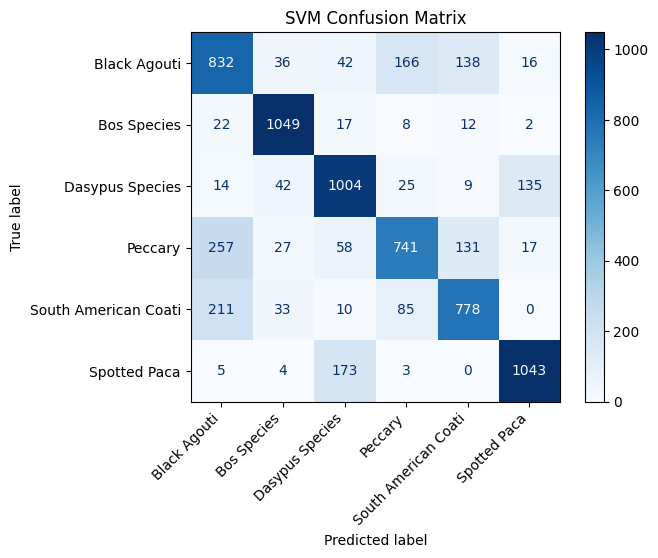

Best-performing model: rbf SVM, with c = 1. Average values over K = 3 folds


In [21]:
cm = confusion_matrix(y_true, y_pred)
label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM Confusion Matrix')
plt.show()
print('Best-performing model: rbf SVM, with c = 1. Average values over K = 3 folds')


## Percentages

<Figure size 1500x1500 with 0 Axes>

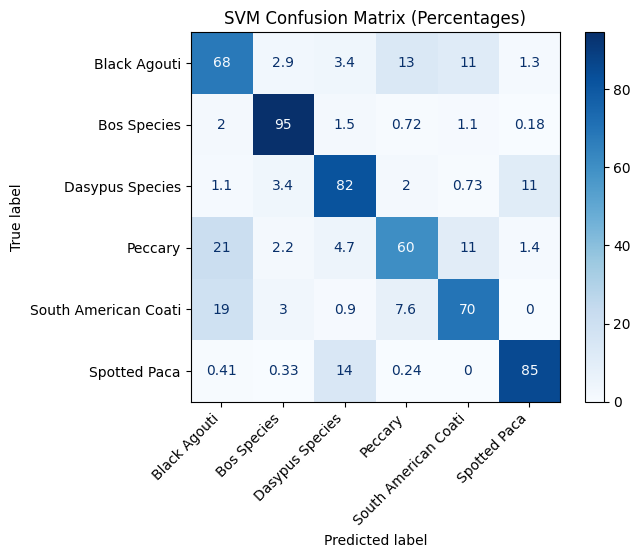

Best-performing model: rbf SVM, with c = 1. Average values over K = 3 folds


In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM Confusion Matrix (Percentages)')
plt.show()
print('Best-performing model: rbf SVM, with c = 1. Average values over K = 3 folds')

## ROC

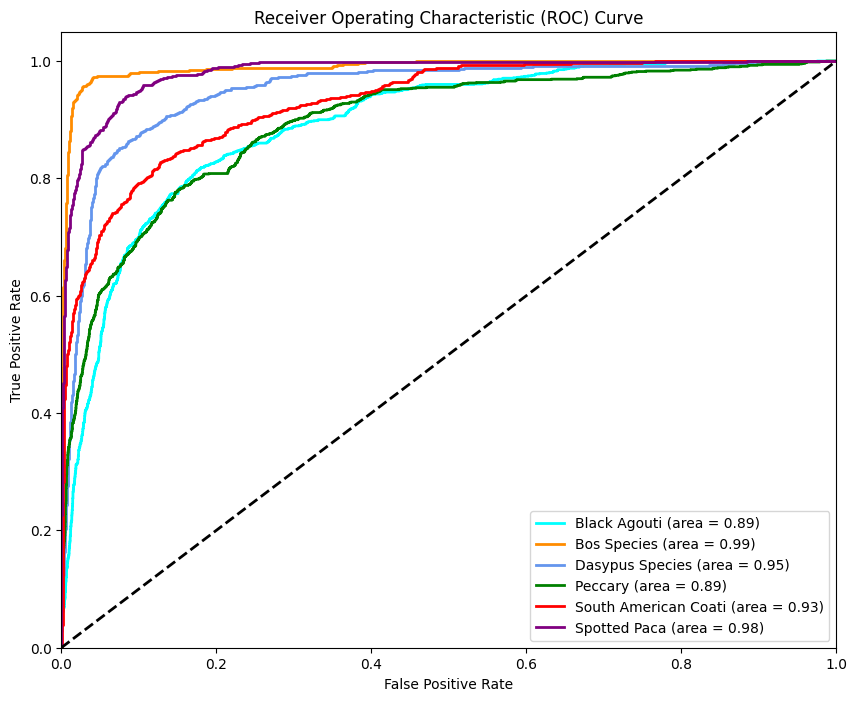

In [23]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gap analysis

- Where is our model stuggling?



In [24]:
# set index as new column
df_with_predictions.reset_index(inplace=True)
df_with_predictions.head()

image    label  \
0  N25_100EK113_03030540.JPG  Peccary   
1  N25_100EK113_03030542.JPG  Peccary   
2  N25_100EK113_03030539.JPG  Peccary   
3  N25_100EK113_03030541.JPG  Peccary   
4  N25_100EK113_03030538.JPG  Peccary   

                                          group  \
0  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
1  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
2  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
3  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   
4  Peccary-398d85ab-7160-11ec-898c-5cf3706028c2   

                                                 pca  predicted_label  \
0  [55.792317241535464, -12.330763604890087, 23.6...                4   
1  [50.831312721021554, -13.051685724356346, 27.6...                5   
2  [54.676390369366395, -14.959894525153459, 27.4...                3   
3  [53.21147595301663, -13.025330853883073, 27.56...                0   
4  [51.98631579379523, -12.25999415228849, 27.655...                1   

    predicted_label_str  
0  South American Coati  
1          Spotted Paca  
2               Peccary  
3          Black Agouti  
4           Bos Species

In [25]:
def visualize_incorrect_predictions(df, input_path_train, input_path_val, num_images=10):
    # Identify incorrect predictions
    incorrect_df = df[df['label'] != df['predicted_label_str']].copy()

    # Limit the number of images to display
    num_images = min(num_images, len(incorrect_df))

    if num_images == 0:
        print("No incorrect predictions found.")
        return

    # Select a random subset of incorrect predictions if there are more than num_images
    if len(incorrect_df) > num_images:
        incorrect_df = incorrect_df.sample(n=num_images)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (idx, row) in enumerate(incorrect_df.iterrows()):
        # Get the image filename
        img_filename = row['image']

        # Check if the image is in the training or validation folder
        img_path_train = os.path.join(input_path_train, img_filename)
        img_path_val = os.path.join(input_path_val, img_filename)

        if os.path.exists(img_path_train):
            img_path = img_path_train
        elif os.path.exists(img_path_val):
            img_path = img_path_val
        else:
            print(f"Image not found: {img_filename}")
            continue

        # Read and display the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i].imshow(image)
        axes[i].set_title(f"True: {row['label']}\nPred: {row['predicted_label_str']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

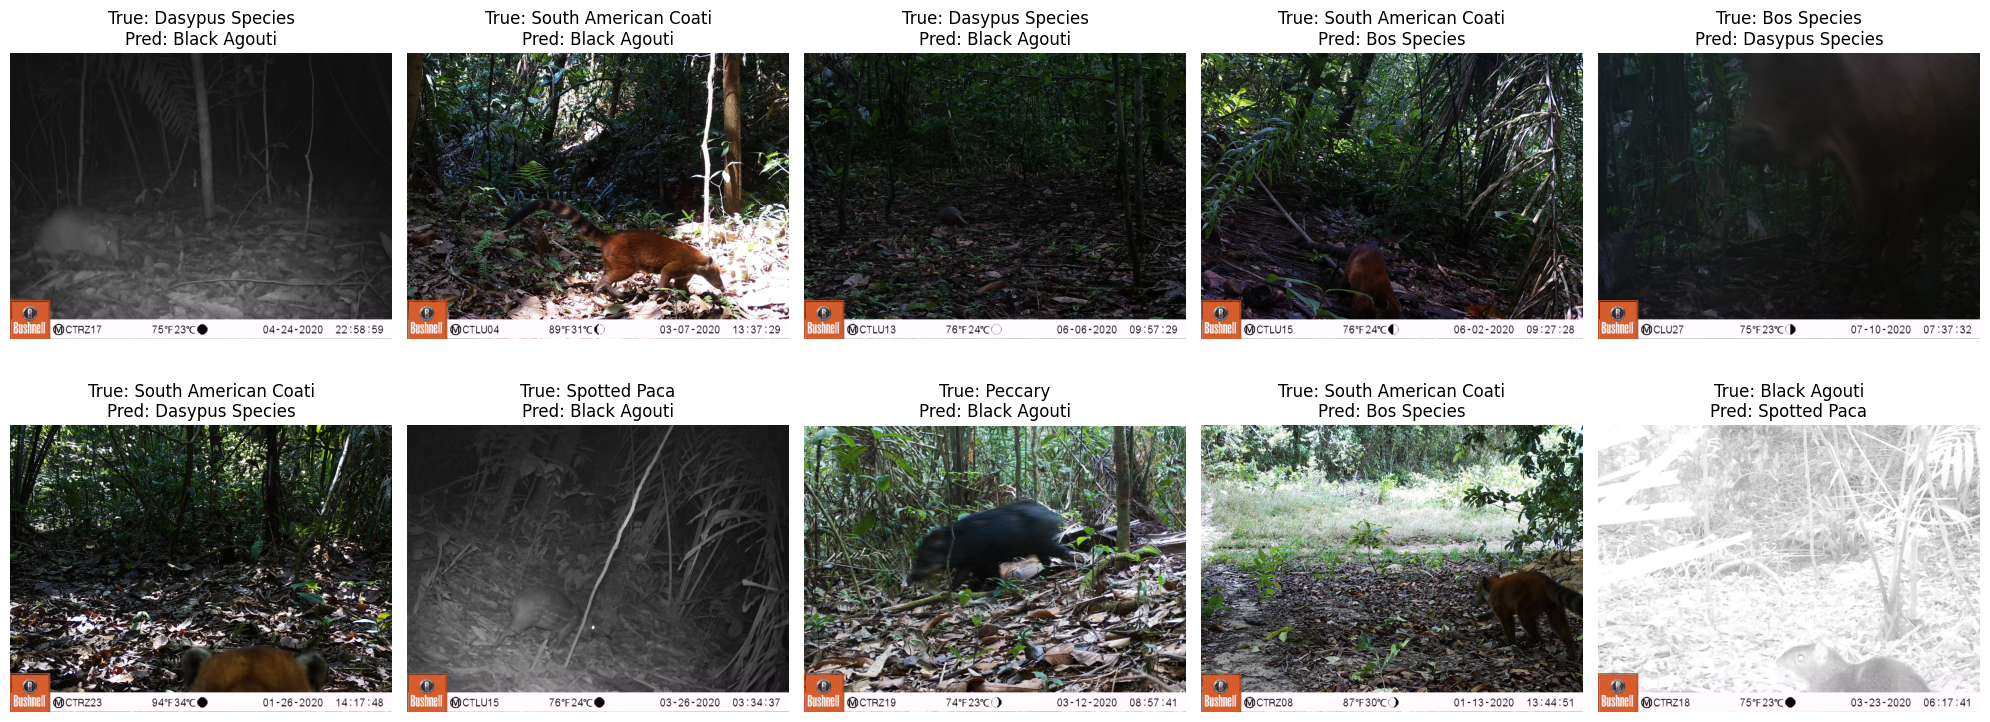

In [26]:
# img_path_train = os.path.join(local_path, 'raw-data/train_data')
# img_path_val = os.path.join(local_path, 'raw-data/validation_data')

input_path_train = img_path_train
input_path_val = img_path_val

visualize_incorrect_predictions(df_with_predictions,input_path_train, input_path_val, num_images=10)

# Test

## Inference

In [27]:
# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Use best_model for inference on df_test
X_test = np.vstack(df_test['pca'].to_numpy())
y_test = df_test['label']
groups = df_test['group']

# Print unique labels in y_test
print("Unique labels in y_test:", np.unique(y_test))

# Shuffle data, keeping groups (if necessary)
# X_test, y_test, groups = shuffle(X_test, y_test, groups, random_state=281)

# Encode the test labels using the loaded label encoder
y_encoded = label_encoder.transform(y_test)
print("Encoded labels:", y_encoded)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

y_true = []
y_pred = []
y_scores = []
incorrect_indices = []
all_predictions = np.empty_like(y_encoded)

# Predict
start_time = time.time()
y_pred_test = best_model.predict(X_test)
end_time = time.time()

# Calculate inference time
test_time = end_time - start_time

# Get decision function scores on the test data (distance to hyperplane)
y_score_test = best_model.decision_function(X_test)

# Store labels
y_true.extend(y_encoded)
y_pred.extend(y_pred_test)
y_scores.extend(y_score_test)
all_predictions[:] = y_pred_test

# Find incorrect predictions
incorrect_pred = np.where(y_encoded != y_pred_test)[0]
incorrect_indices.extend(incorrect_pred)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate the average inference time
print("Test Time: ", test_time, "seconds")

incorrect_indices = np.array(incorrect_indices)

# Calculate overall accuracy
mismatches = np.sum(all_predictions != y_encoded)
overall_accuracy = 1 - mismatches / len(y_encoded)
print(f"Number of mismatches: {mismatches}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Add predictions to df
df_test_with_predictions = df_test.copy()
df_test_with_predictions['predicted_label'] = all_predictions
df_test_with_predictions['predicted_label_str'] = label_encoder.inverse_transform(all_predictions)


Unique labels in y_test: ['Black Agouti' 'Bos Species' 'Dasypus Species' 'Peccary'
 'South American Coati' 'Spotted Paca']
Encoded labels: [3 3 3 ... 1 1 1]
Label mapping: {'Black Agouti': 0, 'Bos Species': 1, 'Dasypus Species': 2, 'Peccary': 3, 'South American Coati': 4, 'Spotted Paca': 5}
Test Time:  28.99933624267578 seconds
Number of mismatches: 433
Overall Accuracy: 0.7586


In [28]:
y_true_test = y_true
y_pred_test = y_pred
y_scores_test = y_scores

In [29]:
# save y_true, y_pred, y_socres and df_test_with_predictions
predictions_path = os.path.join(local_path, 'predictions')
os.makedirs(predictions_path, exist_ok=True)

pickle.dump(y_pred_test, open(predictions_path + '/' + 'svm_y_pred_test' + '.pkl', 'wb'))
pickle.dump(y_scores_test, open(predictions_path + '/' + 'svm_y_scores_test' + '.pkl', 'wb'))
pickle.dump(y_true_test, open(predictions_path + '/' + 'svm_y_true_test' + '.pkl', 'wb'))

#save df_with_predictions
pickle.dump(df_test_with_predictions, open(predictions_path + '/' + 'svm_df_test_with_predictions' + '.pkl', 'wb'))

## Confusion matrix

<Figure size 1500x1500 with 0 Axes>

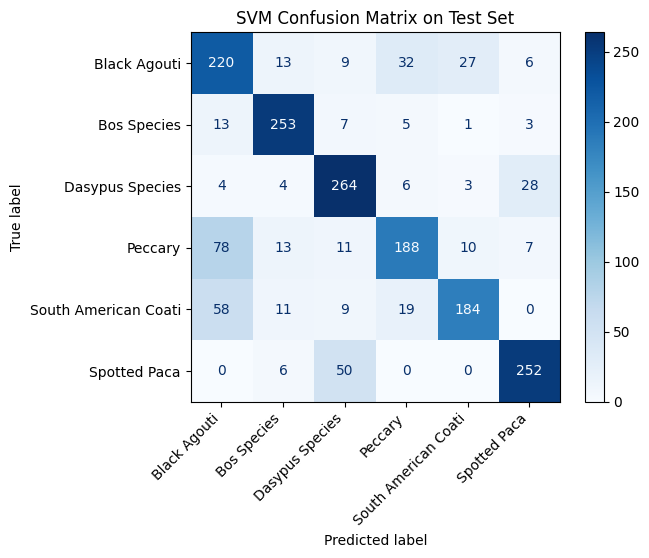

In [30]:
cm = confusion_matrix(y_true_test, y_pred_test)
label_names = label_encoder.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM Confusion Matrix on Test Set')
plt.show()


<Figure size 2000x2000 with 0 Axes>

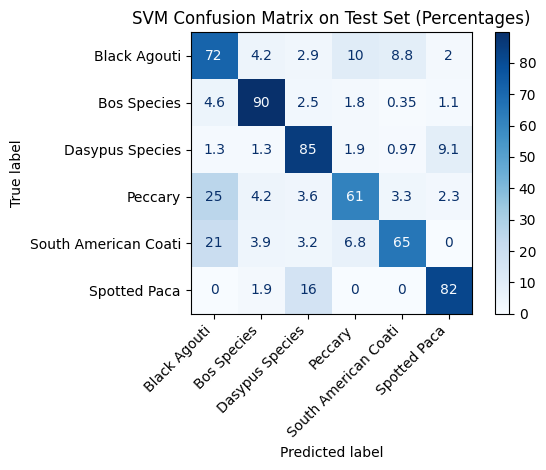

In [31]:
# Create the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Get the label names
label_names = label_encoder.classes_

# Create the confusion matrix plot
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('SVM Confusion Matrix on Test Set (Percentages)')
plt.tight_layout()
plt.show()

## ROC

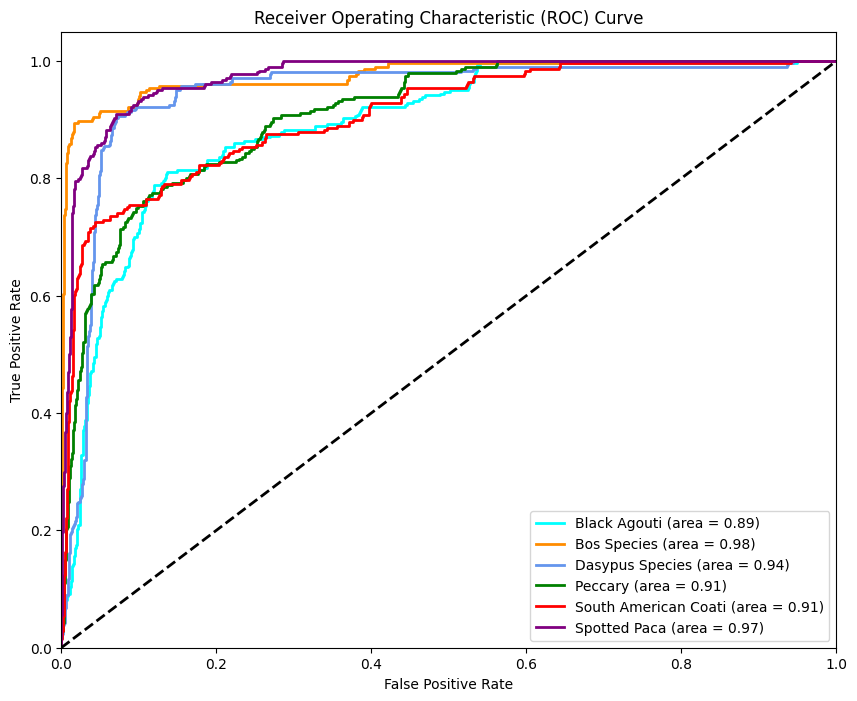

In [32]:
# Define the order and colors for the classes
class_order = ['Black Agouti', 'Bos Species', 'Dasypus Species', 'Peccary', 'South American Coati', 'Spotted Paca']
class_colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

# Create a mapping of class names to colors
class_color_map = {class_name: color for class_name, color in zip(class_order, class_colors)}

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_scores_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot the ROC curves in the specified order
for class_name in class_order:
    class_index = label_encoder.classes_.tolist().index(class_name)
    color = class_color_map[class_name]
    plt.plot(fpr[class_index], tpr[class_index], color=color, lw=2,
             label='{0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[class_index]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Gap Analysis

In [33]:
 # set index as new column
df_test_with_predictions.reset_index(inplace=True)
df_test_with_predictions.head()

image    label  \
0  N29_105EK113_04060336.JPG  Peccary   
1  N29_105EK113_04060328.JPG  Peccary   
2  N29_105EK113_04060331.JPG  Peccary   
3  N29_105EK113_04060326.JPG  Peccary   
4  N29_105EK113_04060335.JPG  Peccary   

                                          group  \
0  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
1  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
2  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
3  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   
4  Peccary-3962c177-7160-11ec-9a5e-5cf3706028c2   

                                                 pca  predicted_label  \
0  [-33.5376012337345, 36.53954216660845, 5.08189...                3   
1  [-26.49372962072319, 21.52699681638688, 2.5873...                3   
2  [-14.697086652508366, 32.607072206525174, -12....                3   
3  [-34.57635955486411, 37.439139447449634, 6.286...                3   
4  [-30.52958668391236, 35.53066249068455, 4.0783...                3   

  predicted_label_str  
0             Peccary  
1             Peccary  
2             Peccary  
3             Peccary  
4             Peccary

In [34]:
test_pre = os.listdir(f"{local_path}/test_data_preprocessed")
raw_test = os.listdir(f"{local_path}/raw-data/test_data")

#check that all images in df_test_with_predictions['image'] are found in test_pre
for img in df_test_with_predictions['image']:
    if img not in test_pre:
        print(f"Image {img} not found in test_pre")

#check that all images in df_test_with_predictions['image'] are found in test_pre
for img in df_test_with_predictions['image']:
    if img not in raw_test:
        print(f"Image {img} not found in raw_test")

# Check the case of filenames in the DataFrame
print(df_test_with_predictions['image'].head())

# Check the case of filenames on disk
print(os.listdir(f"{local_path}/test_data_preprocessed")[:5])


0    N29_105EK113_04060336.JPG
1    N29_105EK113_04060328.JPG
2    N29_105EK113_04060331.JPG
3    N29_105EK113_04060326.JPG
4    N29_105EK113_04060335.JPG
Name: image, dtype: object
['A01_06030796.JPG', 'A01_06030797.JPG', 'A01_06030798.JPG', 'A01_07030835.JPG', 'A01_07030836.JPG']


In [35]:
def visualize_incorrect_predictions(df, input_path_test, num_images=10):
    # Identify incorrect predictions
    incorrect_df = df[df['label'] != df['predicted_label_str']].copy()

    # Limit the number of images to display
    num_images = min(num_images, len(incorrect_df))

    if num_images == 0:
        print("No incorrect predictions found.")
        return

    # Select a random subset of incorrect predictions if there are more than num_images
    if len(incorrect_df) > num_images:
        incorrect_df = incorrect_df.sample(n=num_images)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (idx, row) in enumerate(incorrect_df.iterrows()):
        # Get the image filename
        img_filename = row['image']

        # Construct the full path
        img_path = os.path.join(input_path_test, img_filename)

        # Print the constructed path for debugging
        # print(f"Checking path: {img_path}")

        if os.path.exists(img_path):
            # Read and display the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            axes[i].imshow(image)
            axes[i].set_title(f"True: {row['label']}\nPred: {row['predicted_label_str']}")
            axes[i].axis('off')
        else:
            print(f"Image not found: {img_filename}")

    plt.tight_layout()
    plt.show()


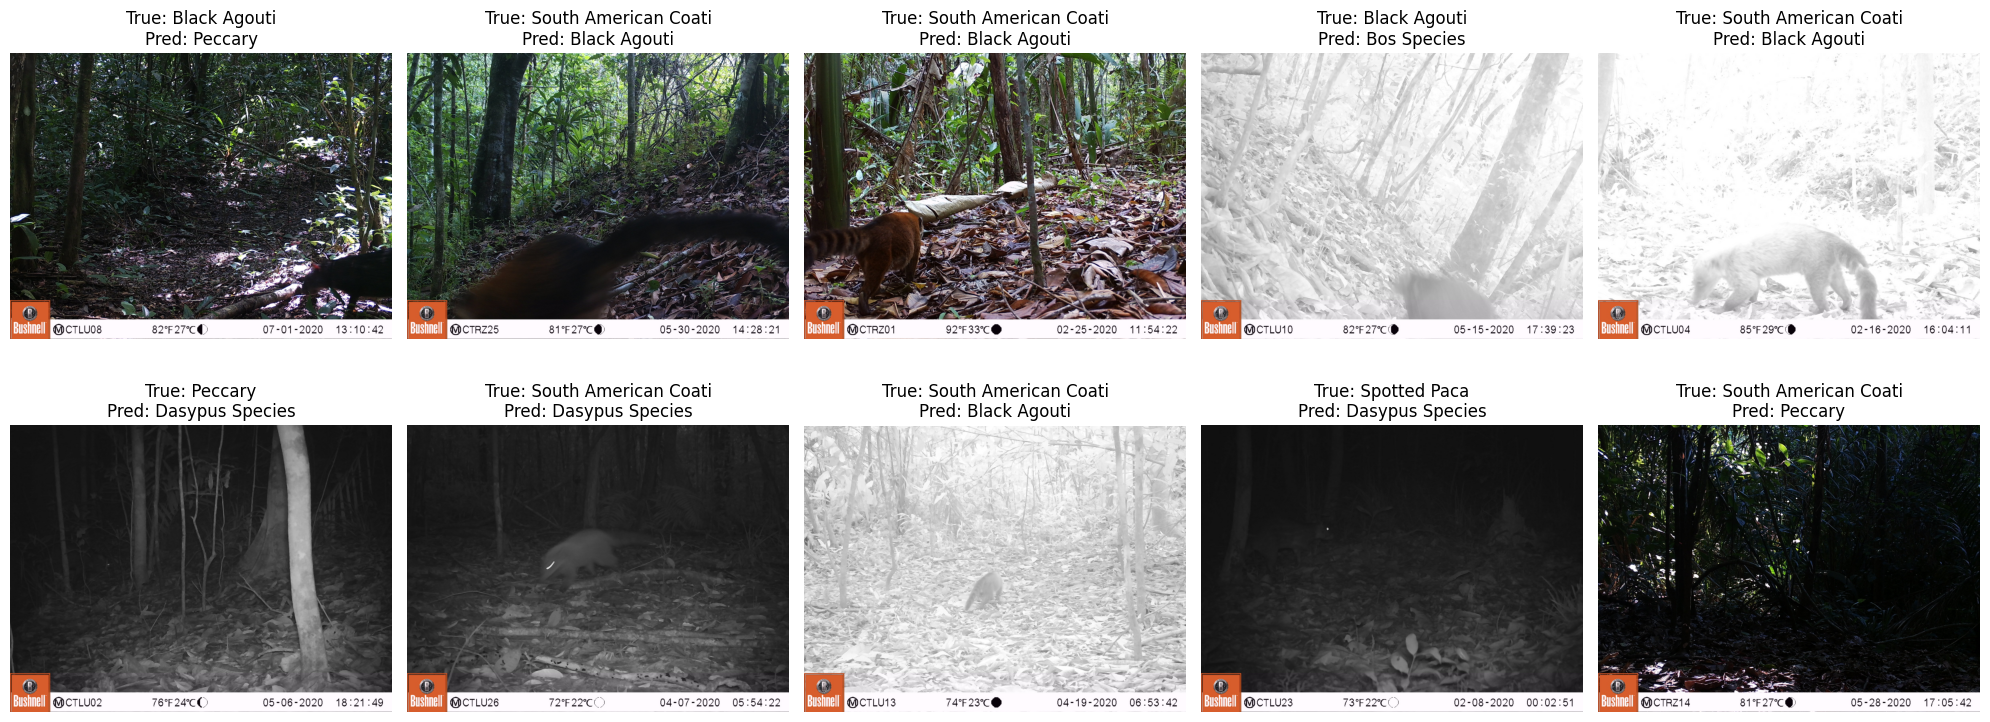

In [36]:
# img_path_test = os.path.join(local_path, 'test_data_preprocessed') #preprocessed
img_path_test = os.path.join(local_path, 'raw-data/test_data') #raw
input_path_test = img_path_test


visualize_incorrect_predictions(df_test_with_predictions,input_path_test, num_images=10)

# Conclusions

-

- During training, the black agouti and peccary were often confused, likely due to their coloring, since both are black, and while the peccary is much larger than the black agouti, without two cameras in place to account for size difference, it's hard to gauge their size when they can be either really close to the camera or far away. Another source of confusion was with the spotted paa and the dasypus species. This is likely due to both of them being nocturnal animals, so that they're eyes reflect the light during night shots, which are the only images the model sees of them, compared to other animals which are seen both in the day and at night.


|Best performing SVM model|Set|Time|Accuracy|ROC per class|
|---|---|---|---|---|
|rbf, c = 1. K = 3 folds.|Train|105.3277|0.7624|Black agouti: 0.89|
|||||Bos species: 0.99|
|||||Dasypus species: 0.95|
|||||Peccary: 0.89|
|||||South American Coati: 0.93|
|||||Spotted Paca: 0.98|
||Test|18.69325|0.7586|Black agouti: 0.89 |
|||||Bos species: 0.98|
|||||Dasypus species: 0.94|
|||||Peccary: 0.91|
|||||South American Coati: 0.91|
|||||Spotted Paca: 0.97|



